# Testing models on the test set

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [43]:
import pandas as pd
import numpy as np
import wandb
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from data.shots_data_retriever import ShotsDataRetriever

## Data pre-processing

In [3]:
shotsDataRetriever = ShotsDataRetriever()
df = shotsDataRetriever.get_df_for_milestone2_test_set()

In [ ]:
df1 = pd.get_dummies(df.drop(columns=['game_id', 'play_num']), columns=['shot_type'])
X = df1.drop(columns=['is_goal'])
y = df1['is_goal']

In [19]:
numeric_features = [
    'period', 'x_coord', 'y_coord', 'is_empty_net', 'distance', 
    'angle_to_goal', 'game_seconds', 'last_event_x_coord', 
    'last_event_y_coord', 'time_since_last_event', 
    'distance_from_last_event', 'rebound', 'angle_change', 'speed'
]

boolean_features = [col for col in X.columns if col.startswith('shot_type_')]

X_test_numeric = X[numeric_features]
X_test_boolean = X[boolean_features]

scaler = StandardScaler()
X_test_numeric_scaled = scaler.fit_transform(X_test_numeric)

X_xgboost_v2 = pd.concat([pd.DataFrame(X_test_numeric_scaled, columns=numeric_features), X_test_boolean], axis=1)
X_base_distance = X[['distance']]
X_base_angle = X[['angle_to_goal']]
X_base_distance_angle = X[['distance', 'angle_to_goal']]
X_xgboost_v0 = X[['angle_to_goal', 'distance']]
X_xgboost_v1 = X

## Load models

In [5]:
run = wandb.init(project="IFT6758.2024-A02", id="get_models", resume="allow")

# Base models
base_distance_path = run.use_model(name="base_distance:v1")
base_angle_path = run.use_model(name="base_angle:v1")
base_distance_angle_path = run.use_model(name="base_distance_angle:v1")

with open(base_distance_path, 'rb') as f:
    base_distance = pickle.load(f)
with open(base_angle_path, 'rb') as f:
    base_angle = pickle.load(f)
with open(base_distance_angle_path, 'rb') as f:
    base_distance_angle = pickle.load(f)

# XGBoost models
xgboost_v0_path = run.use_model(name="xgboost_v0_model:v8")
xgboost_v1_path = run.use_model(name="xgboost_v1_model:v0")
xgboost_v2_path = run.use_model(name="xgboost_v2_model:v0")

with open(xgboost_v0_path, 'rb') as f:
    xgboost_v0 = pickle.load(f)
with open(xgboost_v1_path, 'rb') as f:
    xgboost_v1 = pickle.load(f)
with open(xgboost_v2_path, 'rb') as f:
    xgboost_v2 = pickle.load(f)

# Advanced models - Nathan à rajouter
# Pour trouver la version tu dois aller dans la section "artifacts" dans la toolbar à gauche et dérouler ton modèle

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lofeodo (IFT6758-2024-A02). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


## Make predictions and obtain results

In [29]:
def get_and_log_model_results(id: str, model, X_test, y_test):
    wandb.init(project="IFT6758.2024-A02", id=id, resume="allow")

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_prob)
    wandb.log({
        "accuracy": accuracy,
        "roc_auc": roc_auc,
    })
    print(f"Accuracy: {accuracy}", f"ROC AUC: {roc_auc}")

    results = pd.DataFrame({
        'goal_proba': y_pred_prob,
        'non_goal_proba': 1 - y_pred_prob,
        'is_goal': y_test
    })
    wandb.log({f"results-{id}": wandb.Table(dataframe=results)})

    wandb.finish()

    return results

In [30]:
# Base models
results_base_distance = get_and_log_model_results("base_distance-test_set", base_distance, X_base_distance, y)
results_base_angle = get_and_log_model_results("base_angle-test_set", base_angle, X_base_angle, y)
results_base_distance_angle = get_and_log_model_results("base_distance_angle-test_set", base_distance_angle, X_base_distance_angle, y)

# XGBoost models
results_xgboost_v0 = get_and_log_model_results("xgboost_v0-test_set", xgboost_v0, X_xgboost_v0, y)
results_xgboost_v1 = get_and_log_model_results("xgboost_v1-test_set", xgboost_v1, X_xgboost_v1, y)
results_xgboost_v2 = get_and_log_model_results("xgboost_v2-test_set", xgboost_v2, X_xgboost_v2, y)

# Advanced models - Nathan à rajouter


Accuracy: 0.9019935148410368 ROC AUC: 0.696848968452326


accuracy,▁
roc_auc,▁
accuracy,0.90199
roc_auc,0.69685


Accuracy: 0.9019935148410368 ROC AUC: 0.5116306481994826


accuracy,▁
roc_auc,▁
accuracy,0.90199
roc_auc,0.51163


Accuracy: 0.9019935148410368 ROC AUC: 0.6972973610684795


accuracy,▁
roc_auc,▁
accuracy,0.90199
roc_auc,0.6973


Accuracy: 0.9018208330934976 ROC AUC: 0.7116531645478531


accuracy,▁
roc_auc,▁
accuracy,0.90182
roc_auc,0.71165


Accuracy: 0.9070012855196761 ROC AUC: 0.7781613579434006


accuracy,▁
roc_auc,▁
accuracy,0.907
roc_auc,0.77816


Accuracy: 0.9019935148410368 ROC AUC: 0.55732507630339


accuracy,▁
roc_auc,▁
accuracy,0.90199
roc_auc,0.55733


## Plot performance metrics

In [27]:
figpath = "../../figures/models/test_set"
if not os.path.exists(figpath):
    os.makedirs(figpath)

<Figure size 640x480 with 0 Axes>

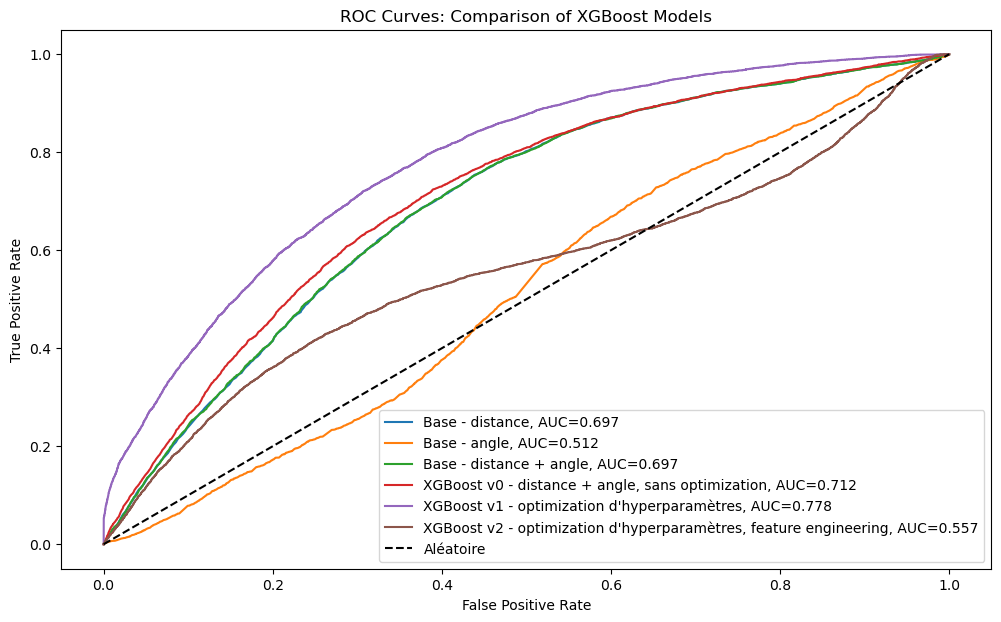

In [34]:
plt.figure(0).clf()
plt.figure(figsize=(12, 7))

fpr, tpr, thresh = metrics.roc_curve(results_base_distance['is_goal'], results_base_distance['goal_proba'])
auc = metrics.roc_auc_score(results_base_distance['is_goal'], results_base_distance['goal_proba'])
plt.plot(fpr, tpr, label="Base - distance, AUC=" + f"{auc:.3f}")

fpr, tpr, thresh = metrics.roc_curve(results_base_angle['is_goal'], results_base_angle['goal_proba'])
auc = metrics.roc_auc_score(results_base_angle['is_goal'], results_base_angle['goal_proba'])
plt.plot(fpr, tpr, label="Base - angle, AUC=" + f"{auc:.3f}")

fpr, tpr, thresh = metrics.roc_curve(results_base_distance_angle['is_goal'], results_base_distance_angle['goal_proba'])
auc = metrics.roc_auc_score(results_base_distance_angle['is_goal'], results_base_distance_angle['goal_proba'])
plt.plot(fpr, tpr, label="Base - distance + angle, AUC=" + f"{auc:.3f}")

fpr, tpr, thresh = metrics.roc_curve(results_xgboost_v0['is_goal'], results_xgboost_v0['goal_proba'])
auc = metrics.roc_auc_score(results_xgboost_v0['is_goal'], results_xgboost_v0['goal_proba'])
plt.plot(fpr, tpr, label="XGBoost v0 - distance + angle, sans optimization, AUC=" + f"{auc:.3f}")

fpr, tpr, thresh = metrics.roc_curve(results_xgboost_v1['is_goal'], results_xgboost_v1['goal_proba'])
auc = metrics.roc_auc_score(results_xgboost_v1['is_goal'], results_xgboost_v1['goal_proba'])
plt.plot(fpr, tpr, label="XGBoost v1 - optimization d'hyperparamètres, AUC=" + f"{auc:.3f}")

fpr, tpr, thresh = metrics.roc_curve(results_xgboost_v2['is_goal'], results_xgboost_v2['goal_proba'])
auc = metrics.roc_auc_score(results_xgboost_v2['is_goal'], results_xgboost_v2['goal_proba'])
plt.plot(fpr, tpr, label="XGBoost v2 - optimization d'hyperparamètres, feature engineering, AUC=" + f"{auc:.3f}")

# À rajouter les modèles avancés

plt.plot([0, 1], [0, 1], 'k--', label="Aléatoire")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Comparison of XGBoost Models")
plt.legend(loc="lower right")

plt.savefig(os.path.join(figpath, "roc.png"))
plt.show()

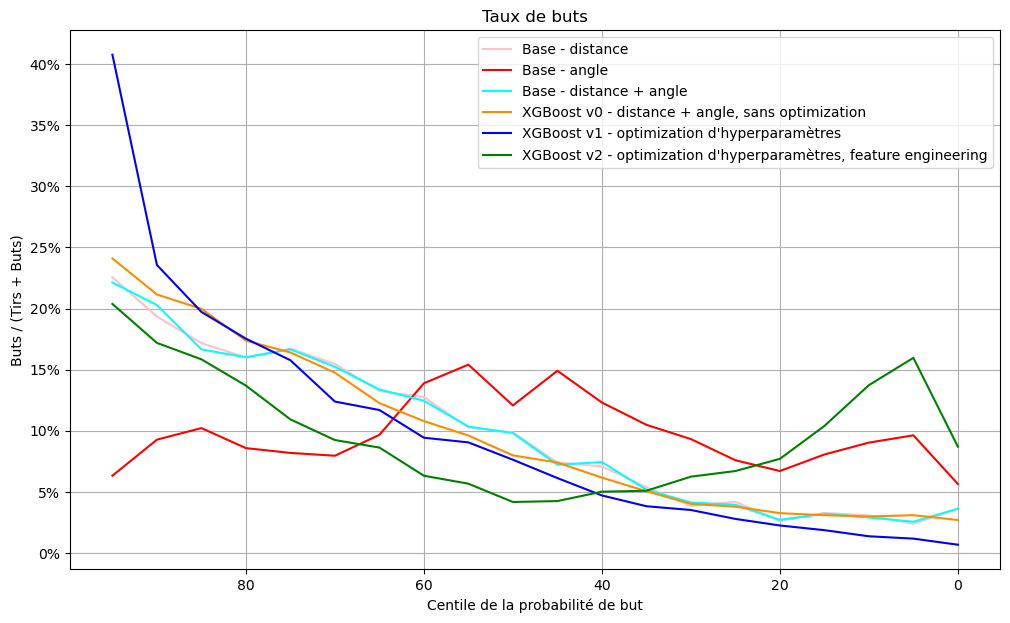

In [41]:
def plot_goal_rates(results, label, color):
    gr_df = results.copy()
    percentile_bins = np.linspace(0, 1, 21)
    gr_df['percentile'] = pd.qcut(
        gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]]
    )
    goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()
    plt.plot(percentile_bins[:-1], goal_rates, color=color, label=label)

plt.figure(figsize=(12, 7))

plot_goal_rates(results_base_distance, label="Base - distance", color='pink')
plot_goal_rates(results_base_angle, label="Base - angle", color='red')
plot_goal_rates(results_base_distance_angle, label="Base - distance + angle", color='cyan')
plot_goal_rates(results_xgboost_v0, label="XGBoost v0 - distance + angle, sans optimization", color='darkorange')
plot_goal_rates(results_xgboost_v1, label="XGBoost v1 - optimization d'hyperparamètres", color='blue')
plot_goal_rates(results_xgboost_v2, label="XGBoost v2 - optimization d'hyperparamètres, feature engineering", color='green')

# À rajouter les modèles avancés

plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts')
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(figpath, "taux_de_buts.png"))
plt.show()

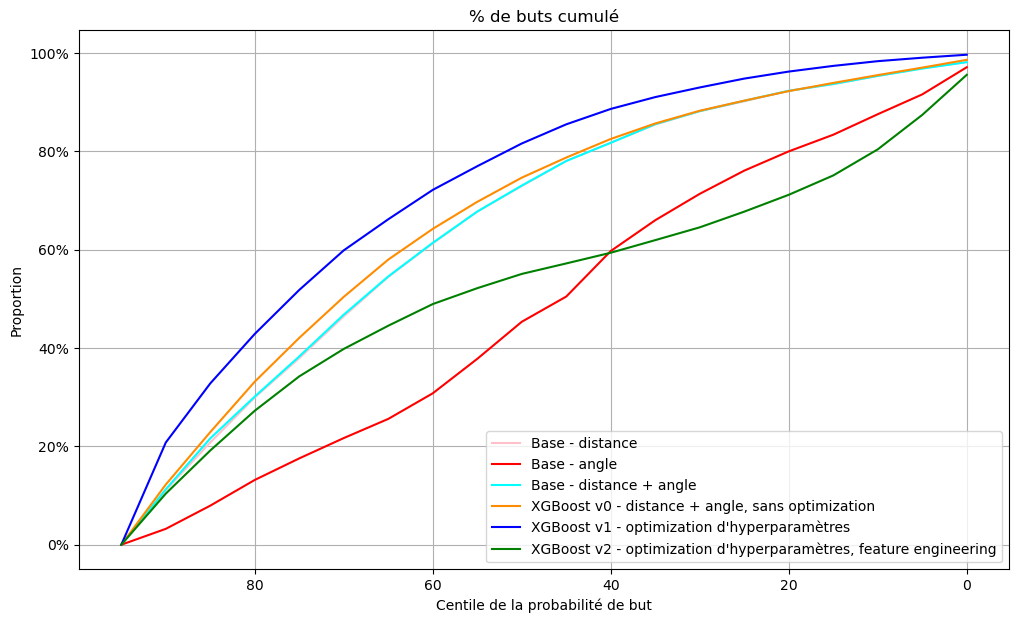

In [ ]:
def plot_cumulative_goals(results, label, color):
    cg_df = results.copy()
    percentile_bins = np.linspace(0, 1, 21)
    cg_df['percentile'] = pd.qcut(
        cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]]
    )
    total_goals = cg_df['is_goal'].sum()
    goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_goals
    plt.plot(percentile_bins[:-1], goals_cums, color=color, label=label)

plt.figure(figsize=(12, 7))

plot_cumulative_goals(results_base_distance, label="Base - distance", color='pink')
plot_cumulative_goals(results_base_angle, label="Base - angle", color='red')
plot_cumulative_goals(results_base_distance_angle, label="Base - distance + angle", color='cyan')
plot_cumulative_goals(results_xgboost_v0, label="XGBoost v0 - distance + angle, sans optimization", color='darkorange')
plot_cumulative_goals(results_xgboost_v1, label="XGBoost v1 - optimization d'hyperparamètres", color='blue')
plot_cumulative_goals(results_xgboost_v2, label="XGBoost v2 - optimization d'hyperparamètres, feature engineering", color='green')

# À rajouter les modèles avancés

plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))

plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé')

plt.legend()
plt.grid(True)

plt.savefig(os.path.join(figpath, "buts_cumul.png"))
plt.show()


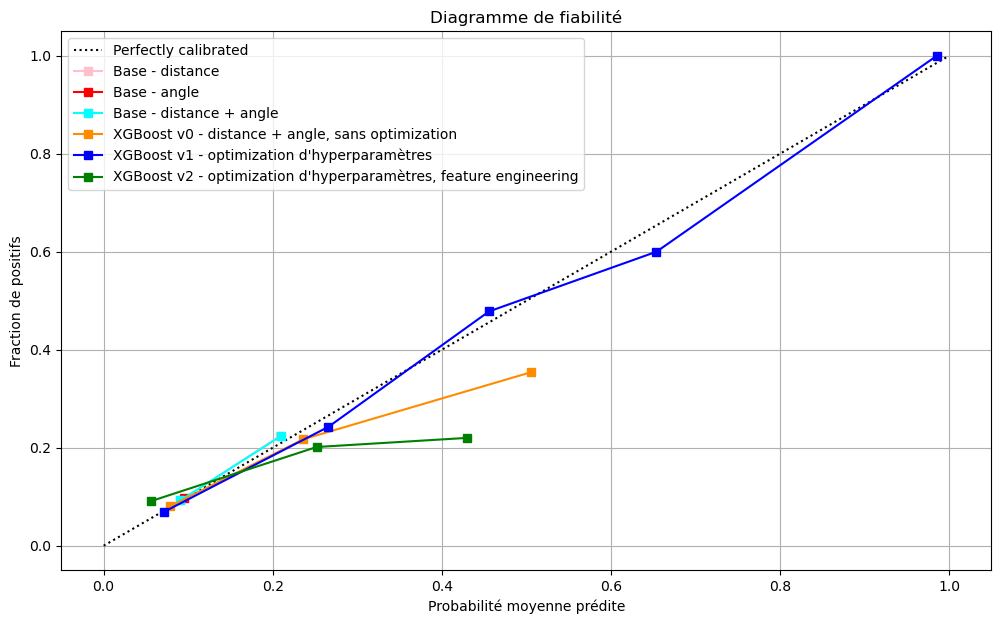

In [44]:
def plot_calibration_curve(results, label, color):
    CalibrationDisplay.from_predictions(
        results['is_goal'],
        results['goal_proba'],
        name=label,
        color=color,
        ax=plt.gca()
    )

plt.figure(figsize=(12, 7))

plot_calibration_curve(results_base_distance, label="Base - distance", color='pink')
plot_calibration_curve(results_base_angle, label="Base - angle", color='red')
plot_calibration_curve(results_base_distance_angle, label="Base - distance + angle", color='cyan')
plot_calibration_curve(results_xgboost_v0, label="XGBoost v0 - distance + angle, sans optimization", color='darkorange')
plot_calibration_curve(results_xgboost_v1, label="XGBoost v1 - optimization d'hyperparamètres", color='blue')
plot_calibration_curve(results_xgboost_v2, label="XGBoost v2 - optimization d'hyperparamètres, feature engineering", color='green')

# À rajouter les modèles avancés

plt.title("Diagramme de fiabilité")
plt.xlabel("Probabilité moyenne prédite")
plt.ylabel("Fraction de positifs")
plt.legend(loc="best")
plt.grid(True)

plt.savefig(os.path.join(figpath, "diag_fiab.png"))
plt.show()